In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install mne

In [ ]:
import matplotlib.pyplot as plt
import pickle
import numpy as np

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

import mne
from mne.decoding import (SlidingEstimator, cross_val_multiscore)

In [ ]:
# with open('drive/MyDrive/bce/RNN_data_21-18-17_23-07-2023.pkl', 'rb') as f:
with open('drive/MyDrive/RNN_data_21-18-17_23-07-2023.pkl', 'rb') as f:
    RNN_data = pickle.load(f)

In [ ]:
RNN_data['y_t'][:,-1,:]

array([[0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.]])

In [ ]:
RNN_data.keys()

dict_keys(['x_t', 'y_t', 'mask_t', 'task_parameters', 'losses', 'network_params', 'train_params', 'output_units_activity', 'hidden_units_activity', 'final_accuracy'])

In [ ]:
RNN_data["task_parameters"]

array([{'stim1_onset_time': 200, 'stim1_duration': 200, 'delay_between_stimuli': 500, 'delay_before_decision_time': 500, 'stim2_duration': 200, 'decision_time_duration': 800, 'stim_noise': 0.1, 'dt': 10, 'tau': 100, 'T': 2400, 'N_batch': 50, 'N_rec': 50, 'name': 'basicModel', 'angle1': 6.05498007326237, 'angle2': 4.8064902511154175, 'category1': 1, 'category2': 1, 'stim1_end_time': 400, 'stim2_onset_time': 900, 'stim2_end_time': 1100, 'decision_time_onset': 1600, 'decision_time_end': 2400},
       {'stim1_onset_time': 200, 'stim1_duration': 200, 'delay_between_stimuli': 500, 'delay_before_decision_time': 500, 'stim2_duration': 200, 'decision_time_duration': 800, 'stim_noise': 0.1, 'dt': 10, 'tau': 100, 'T': 2400, 'N_batch': 50, 'N_rec': 50, 'name': 'basicModel', 'angle1': 6.05498007326237, 'angle2': 4.8064902511154175, 'category1': 1, 'category2': 1, 'stim1_end_time': 400, 'stim2_onset_time': 900, 'stim2_end_time': 1100, 'decision_time_onset': 1600, 'decision_time_end': 2400},
       {

In [ ]:
RNN_data['y_t'][:,-1,:]

array([[0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.]])

In [ ]:
# warning: np.reshape does weird stuffs...
# X, y = RNN_data['hidden_units_activity'].reshape((50, 50, 240)), RNN_data['y_t'][:,-1,:]
print(RNN_data['hidden_units_activity'].shape)
print(np.moveaxis(RNN_data['hidden_units_activity'], 2, 1).shape)

# safer to use np.moveaxis to reshaped the data in a format expected by MNE (i.e., trials x units x time steps)
X = np.moveaxis(RNN_data['hidden_units_activity'], 2, 1)
y = RNN_data['y_t'][:,-1,:]

print(y.shape[0])
new_y = np.zeros((y.shape[0]))
new_y[np.where(y[:,0] > y[:,1])] = 1
y = new_y

print(X.shape)
print(y.shape)

# X, y = RNN_data['hidden_units_activity'][:4,:,:].reshape((4,50, 240)), np.array([0,1,0,1])
# print(X.shape)
# print(y.shape)

(50, 240, 50)
(50, 50, 240)
50
(50, 50, 240)
(50,)


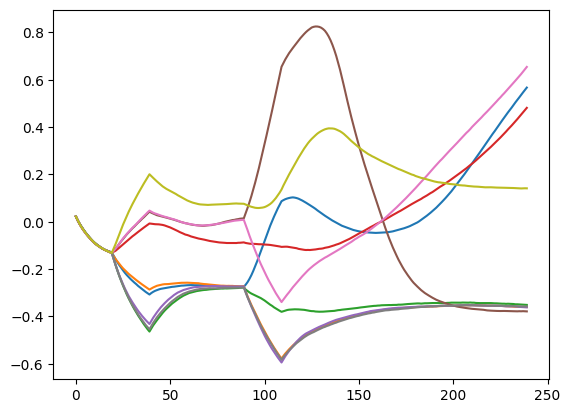

In [ ]:
for i in range (1, 10): plt.plot(RNN_data['hidden_units_activity'][i, :, 0])

In [ ]:
RNN_data['hidden_units_activity'].shape
# RNN_data['y_t'].shape
# new_y
# RNN_data['y_t']

(50, 240, 50)

  0%|          | Fitting SlidingEstimator : 0/240 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/240 [00:00<?,       ?it/s]

(50, 240)


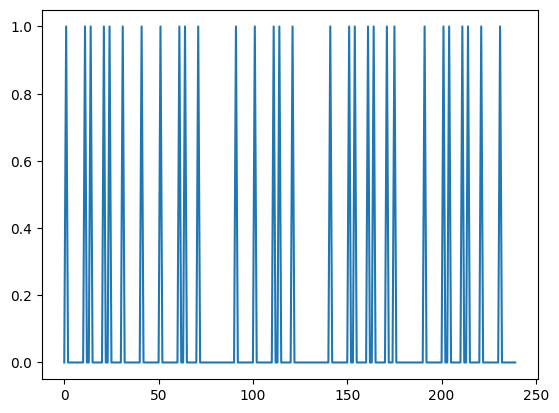

In [ ]:
# https://mne.tools/stable/auto_tutorials/machine-learning/50_decoding.html#decoding-over-time

clf = make_pipeline(StandardScaler(), LogisticRegression(solver="liblinear"))

time_decod = SlidingEstimator(clf, n_jobs=None, scoring="roc_auc", verbose=True)
time_decod = time_decod.fit(X,y)
y_pred = time_decod.transform(X)
print(y_pred.shape)
plt.plot(y_pred[0,:])

# # here we use cv=3 just for speed
# scores = cross_val_multiscore(time_decod, X, y, cv=3, n_jobs=None)

# # Mean scores across cross-validation splits
# scores = np.mean(scores, axis=0)

# # Plot
# fig, ax = plt.subplots()
# ax.plot([i for i in range(240)], scores, label="score")
# ax.axhline(0.5, color="k", linestyle="--", label="chance")
# ax.set_xlabel("Times")
# ax.set_ylabel("AUC")  # Area Under the Curve
# ax.legend()
# # ax.axvline(0.0, color="k", linestyle="-")
# ax.set_title("Sensor space decoding")

In [ ]:
# training the classifier on matching vs. non-matching trials
clf = make_pipeline(StandardScaler(), LogisticRegression(solver = "liblinear") )
time_decod = SlidingEstimator(clf, n_jobs = None, scoring = "roc_auc", verbose = True)

# computing the cross-validated accuracy
# scores = cross_val_multiscore(time_decod, X, y, cv = 4, n_jobs = 4)
scores = cross_val_multiscore(time_decod, X, y, cv = 8, n_jobs = None)

# mean scores across cross-validation splits
scores = np.mean(scores, axis = 0)

  0%|          | Fitting SlidingEstimator : 0/240 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/240 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/240 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/240 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/240 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/240 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/240 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/240 [00:00<?,       ?it/s]

<ipython-input-71-0ec615606087>:3: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  style.use('seaborn-colorblind')


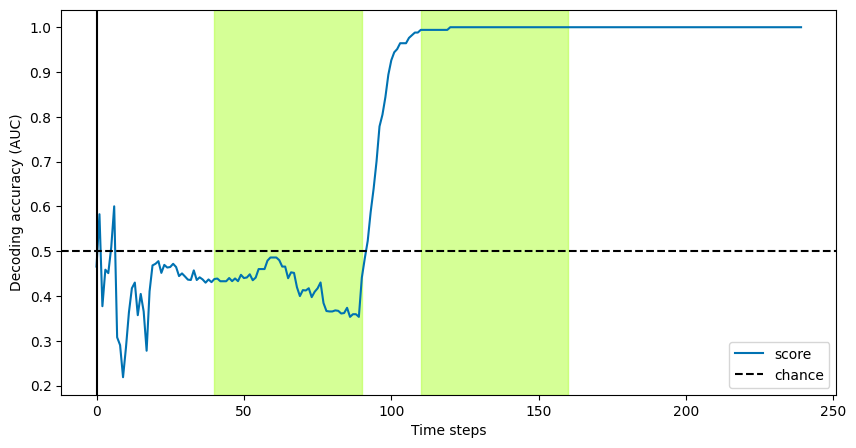

In [ ]:
# using a colorblind-freidnly palette
import matplotlib.style as style
style.use('seaborn-colorblind')

# defining the two periods of interest (delay 1 and delay 2)
tp = RNN_data['task_parameters'][0]
stim1_onset = tp['stim1_onset_time']
stim2_onset = tp['stim1_onset_time'] + tp['stim1_duration'] + tp['delay_between_stimuli']
decision_time_onset = tp['stim1_onset_time'] + tp['stim1_duration'] + tp['delay_between_stimuli'] + tp['stim2_duration'] + tp['delay_before_decision_time']

start_first_delay = (tp['stim1_onset_time'] + tp['stim1_duration']) / tp['dt']
end_first_delay = (tp['stim1_onset_time'] + tp['stim1_duration'] + tp['delay_between_stimuli']) / tp['dt']
start_second_delay = (tp['stim1_onset_time'] + tp['stim1_duration'] + tp['delay_between_stimuli'] + tp['stim2_duration']) / tp['dt']
end_second_delay = decision_time_onset / tp['dt']

# plotting decoding accuracy over time
fig, ax = plt.subplots(figsize = [10, 5])
# fig.savefig(fname = "figures/temporal_decoding.png", dpi = 200)
ax.axvspan(start_first_delay, end_first_delay, alpha = 0.5, color = "greenyellow")
ax.axvspan(start_second_delay, end_second_delay, alpha = 0.5, color = "greenyellow")
ax.plot(np.arange(len(scores) ), np.diag(scores), label = "score")
ax.axhline(0.5, color = "k", linestyle = "--", label  ="chance")
ax.set_xlabel("Time steps")
ax.set_ylabel("Decoding accuracy (AUC)")
ax.legend()
ax.axvline(0.0, color = "k", linestyle = "-")
# ax.set_title("Sensor space decoding")
fig.savefig(fname = "temporal_decoding.png", dpi = 200)

In [ ]:
from mne.decoding import (
    SlidingEstimator,
    GeneralizingEstimator,
    Scaler,
    cross_val_multiscore,
    LinearModel,
    get_coef,
    Vectorizer,
    CSP
    )

# defining the temporal generalization object
time_gen = GeneralizingEstimator(clf, n_jobs = None, scoring = "roc_auc", verbose = True)

# computing the cross-validated score (this can take a while to run...)
scores = cross_val_multiscore(time_gen, X, y, cv = 4, n_jobs = None)

# mean scores across cross-validation splits
scores = np.mean(scores, axis = 0)

  0%|          | Fitting GeneralizingEstimator : 0/240 [00:00<?,       ?it/s]

  0%|          | Scoring GeneralizingEstimator : 0/57600 [00:00<?,       ?it/s]

  0%|          | Fitting GeneralizingEstimator : 0/240 [00:00<?,       ?it/s]

  0%|          | Scoring GeneralizingEstimator : 0/57600 [00:00<?,       ?it/s]

  0%|          | Fitting GeneralizingEstimator : 0/240 [00:00<?,       ?it/s]

  0%|          | Scoring GeneralizingEstimator : 0/57600 [00:00<?,       ?it/s]

  0%|          | Fitting GeneralizingEstimator : 0/240 [00:00<?,       ?it/s]

  0%|          | Scoring GeneralizingEstimator : 0/57600 [00:00<?,       ?it/s]

<ipython-input-68-08fa3645846f>:3: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  style.use('seaborn-colorblind')


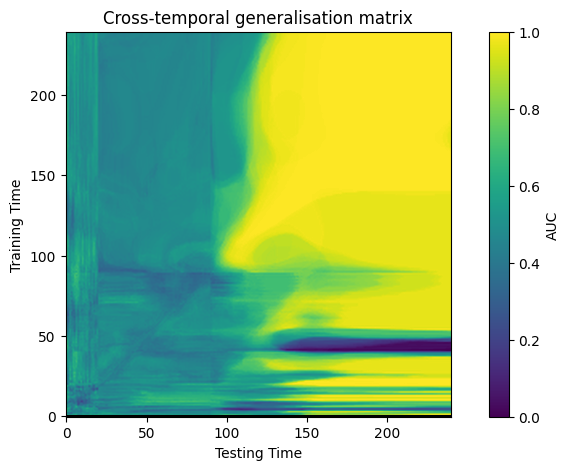

In [ ]:
# plotting the full temporal generalisation matrix
fig, ax = plt.subplots(figsize = [10, 5])

im = ax.imshow(
    scores,
    interpolation = "lanczos",
    origin = "lower"
    # cmap = "RdBu_r",
    # extent = epochs.times[[0, -1, 0, -1]],
    # extent = np.arange(len(scores) ),
    # vmin = 0.0,
    # vmax = 1.0,
    )

ax.set_xlabel("Testing Time")
ax.set_ylabel("Training Time")
ax.set_title("Cross-temporal generalisation matrix")
ax.axvline(0, color="k")
ax.axhline(0, color="k")
cbar = plt.colorbar(im, ax = ax)
cbar.set_label("AUC")
fig.savefig(fname = "cross_temporal_decoding.png", dpi = 200)